In [10]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions
from collections import namedtuple
from itertools import count

device = "cuda:0"

batchsize = 512
nsamples = 8
npoints = 5
emsize = 512


class Graph_Transformer(nn.Module):
    def __init__(self, emsize = 32, nhead = 8, nhid = 1024, nlayers = 4, ndecoderlayers = 2, dropout = 0):
        super().__init__()
        self.emsize = emsize
        from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
        encoder_layers = TransformerEncoderLayer(emsize, nhead, nhid, dropout = dropout)
        decoder_layers = TransformerDecoderLayer(emsize, nhead, nhid, dropout = dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.transformer_decoder = TransformerDecoder(decoder_layers, ndecoderlayers)
        self.encoder = nn.Linear(2, emsize)
        self.outputattention_query = nn.Linear(emsize, emsize, bias = False)
        self.outputattention_key = nn.Linear(emsize, emsize, bias = False)
        self.start_token = nn.Parameter(torch.randn([emsize], device = device))
        
        self.lineartest0 = nn.Linear(2, emsize)
        self.lineartest1 = nn.Linear(2, emsize)
        self.lineartest2 = nn.Linear(2, emsize)
        self.lineartest3 = nn.Linear(2 * emsize, emsize)
    
    def generate_subsequent_mask(self, sz): #last dimension will be softmaxed over when adding to attention logits, if boolean the ones turn into -inf
        #mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        #mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        
        mask = torch.triu(torch.ones([sz, sz], dtype = torch.bool, device = device), diagonal = 1)
        return mask
    
    def encode(self, src): #src must be [batchsize * nsamples, npoints, 2]
        src = self.encoder(src).transpose(0, 1)
        output = self.transformer_encoder(src)
        return output #[npoints, batchsize * nsamples, emsize]
    
    def test_encode(self, src): #src must be [batchsize * nsamples, npoints = 5, 2]
        point_1 = self.lineartest1(src[:, 3, :] - 0.5) #want mean 0!!!!
        point_2 = self.lineartest1(src[:, 4, :] - 0.5)
        remaining = self.lineartest0(src[:, :3, :]) #[batchsize * nsamples, 3, emsize]
        point_1_message = self.lineartest1(src[:, 3, :] - 0.5).squeeze(1)
        point_2_message = self.lineartest2(src[:, 4, :] - 0.5).squeeze(1)
        point_1 = F.relu(torch.cat([point_1, point_2_message], dim = 1))
        point_2 = F.relu(torch.cat([point_2, point_1_message], dim = 1))
        point_1 = self.lineartest3(point_1)
        point_2 = self.lineartest3(point_2)
        src = torch.cat([torch.zeros_like(remaining.transpose(0, 1)), point_1.unsqueeze(0), point_2.unsqueeze(0)])
        return src #[npoints = 5, batchsize * nsamples, emsize]
    
    def decode_next(self, memory, tgt, route_mask): #route mask is [batchsize * nsamples, npoints], both memory and tgt must have batchsize and nsamples in same dimension (the 1th one)
        npoints = memory.size(0)
        batchsize = tgt.size(1)
        """if I really wanted this to be efficient I'd only recompute the decoder for the last tgt, and just remebering what the others looked like from before (won't change due to mask)"""
        """have the option to freeze the autograd on all but the last part of tgt, although at the moment this is a very natural way to say: initial choices matter more"""
        tgt_mask = self.generate_subsequent_mask(tgt.size(0))
        output = self.transformer_decoder(tgt, memory, tgt_mask) #[tgt, batchsize * nsamples, emsize]
        output_query = self.outputattention_query(memory).transpose(0, 1) #[batchsize * nsamples, npoints, emsize]
        output_key = self.outputattention_key(output[-1]) #[batchsize * nsamples, emsize]
        output_attention = torch.matmul(output_query * self.emsize ** -0.5, output_key.unsqueeze(-1)).squeeze(-1) #[batchsize * nsamples, npoints], technically don't need to scale attention as we divide by variance next anyway
        output_attention_tanh = output_attention.tanh() #[batchsize * nsamples, npoints]
        
        #we clone the route_mask incase we want to backprop using it (else it was modified by inplace opporations)
        output_attention = output_attention.masked_fill(route_mask.clone(), float('-inf')) #[batchsize * nsamples, npoints]
        output_attention_tanh = output_attention_tanh.masked_fill(route_mask.clone(), float('-inf')) #[batchsize * nsamples, npoints]
        
        return output_attention_tanh, output_attention #[batchsize * nsamples, npoints]
    
    def calculate_logprob(self, memory, routes): #memory is [npoints, batchsize * nsamples, emsize], routes is [batchsize * nsamples, npoints - 3], rather than backproping the entire loop, this saves vram (and computation)
        npoints = memory.size(0)
        ninternalpoints = routes.size(1)
        bigbatchsize = memory.size(1)
        memory_ = memory.gather(0, routes.transpose(0, 1).unsqueeze(2).expand(-1, -1, self.emsize)) #[npoints - 3, batchsize * nsamples, emsize] reorder memory into order of routes
        tgt = torch.cat([self.start_token.unsqueeze(0).unsqueeze(1).expand(1, bigbatchsize, -1), memory_[:-1]]) #[npoints - 3, batchsize * nroutes, emsize], want to go from memory to tgt
        tgt_mask = self.generate_subsequent_mask(ninternalpoints)
        output = self.transformer_decoder(tgt, memory, tgt_mask) #[npoints - 3, batchsize * nsamples, emsize]
        """want probability of going from key to query, but first need to normalise (softmax with mask)"""
        output_query = self.outputattention_query(memory_).transpose(0, 1) #[batchsize * nsamples, npoints - 3, emsize]
        output_key = self.outputattention_key(output).transpose(0, 1) #[batchsize * nsamples, npoints - 3, emsize]
        attention_mask = torch.full([ninternalpoints, ninternalpoints], True, dtype = torch.bool, device = device).triu(1) #[npoints - 3, npoints - 3], True for i < j
        output_attention = torch.matmul(output_query * self.emsize ** -0.5, output_key.transpose(-1, -2))
        """quick fix to stop divergence"""
        output_attention_tanh = output_attention.tanh()
        
        output_attention_tanh = output_attention_tanh.masked_fill(attention_mask, float('-inf'))
        output_attention_tanh = output_attention_tanh - output_attention_tanh.logsumexp(-2, keepdim = True) #[batchsize * nsamples, npoints - 3, npoints - 3]
        
        output_attention = output_attention.masked_fill(attention_mask, float('-inf'))
        output_attention = output_attention - output_attention.logsumexp(-2, keepdim = True) #[batchsize * nsamples, npoints - 3, npoints - 3]
        
        """infact I'm almost tempted to not mask choosing a previous point, so it's forced to learn it and somehow incorporate it into its computation, but without much impact on reinforcing good examples"""
        logprob_tanh = output_attention_tanh.diagonal(dim1 = -1, dim2 = -2).sum(-1) #[batchsize * nsamples]
        logprob = output_attention.diagonal(dim1 = -1, dim2 = -2).sum(-1) #[batchsize * nsamples]
        return logprob_tanh, logprob #[batchsize * nsamples]

NN = Graph_Transformer().to(device)
optimizer = optim.Adam(NN.parameters())


class environment():
    def reset(self, npoints, batchsize, nsamples):
        if npoints <= 3:
            print("Error: not enough points for valid problem instance")
            return
        self.batchsize = batchsize * nsamples #so that I don't have to rewrite all this code, we store these two dimensions together
        self.nsamples = nsamples
        self.npoints = npoints
        self.points = torch.rand([batchsize, npoints - 3, 2], device = device).unsqueeze(1).expand(-1, nsamples, -1, -1).reshape(self.batchsize, npoints - 3, 2)
        self.corner_points = torch.tensor([[0, 0], [2, 0], [0, 2]], dtype = torch.float, device = device)
        self.points = torch.cat([self.corner_points.unsqueeze(0).expand(self.batchsize, -1, -1), self.points], dim = -2) #[batchsize * nsamples, npoints, 2]
        self.points_mask = torch.cat([torch.ones([self.batchsize, 3], dtype = torch.bool, device = device), torch.zeros([self.batchsize, npoints - 3], dtype = torch.bool, device = device)], dim = 1)
        self.points_sequence = torch.empty([self.batchsize, 0], dtype = torch.long, device = device)
        
        """use a trick, for the purpose of an 'external' triangle that is always left untouched, which means we don't have to deal with boundary edges as being different. external triangle is [0, 1, 2] traversed clockwise..."""
        self.partial_delaunay_triangles = torch.tensor([[0, 2, 1], [0, 1, 2]], dtype = torch.int64, device = device).unsqueeze(0).expand(self.batchsize, -1, -1).contiguous() #[batchsize, ntriangles, 3] contains index of points, always anticlockwise
        self.partial_delaunay_edges = torch.tensor([5, 4, 3, 2, 1, 0], dtype = torch.int64, device = device).unsqueeze(0).expand(self.batchsize, -1).contiguous() #[batchsize, ntriangles * 3] contains location of corresponding edge (edges go in order 01, 12, 20). Edges will always flip since triangles are stored anticlockwise.
        
        self.ntriangles = 2 #can store as scalar, since will always be the same
        self.cost = torch.zeros([self.batchsize], device = device)
        
        self.logprob = torch.zeros([self.batchsize], device = device, requires_grad = True)
    
    def update(self, point_index): #point_index is [batchsize]
        if point_index.size(0) != self.batchsize:
            print("Error: point_index.size() doesn't match expected size, should be [batchsize]")
            return
        if self.points_mask.gather(1, point_index.unsqueeze(1)).sum():
            print("Error: some points already added")
            return
        triangles_coordinates = self.points.gather(1, self.partial_delaunay_triangles.view(self.batchsize, self.ntriangles * 3).unsqueeze(2).expand(-1, -1, 2)).view(self.batchsize, self.ntriangles, 3, 2) #[batchsize, ntriangles, 3, 2]
        newpoint = self.points.gather(1, point_index.unsqueeze(1).unsqueeze(2).expand(self.batchsize, 1, 2)).squeeze(1) #[batchsize, 2]
        
        incircle_matrix = torch.cat([triangles_coordinates, newpoint.unsqueeze(1).unsqueeze(2).expand(-1, self.ntriangles, 1, -1)], dim = -2) #[batchsize, ntriangles, 4, 2]
        incircle_matrix = torch.cat([incircle_matrix, (incircle_matrix * incircle_matrix).sum(-1, keepdim = True), torch.ones([self.batchsize, self.ntriangles, 4, 1], device = device)], dim = -1) #[batchsize, ntriangles, 4, 4]
        incircle_test = incircle_matrix.det() > 0 #[batchsize, ntriangles], is True if inside incircle
        removed_edge_mask = incircle_test.unsqueeze(2).expand(-1, -1, 3).reshape(-1) #[batchsize * ntriangles * 3]
        
        edges = (self.partial_delaunay_edges + self.ntriangles * 3 * torch.arange(self.batchsize, device = device).unsqueeze(1)).view(-1) #[batchsize * ntriangles * 3]
        neighbouring_edge = edges.masked_select(removed_edge_mask)
        neighbouring_edge_mask = torch.zeros([self.batchsize * self.ntriangles * 3], device = device, dtype = torch.bool)
        neighbouring_edge_mask[neighbouring_edge] = True
        neighbouring_edge_mask = (neighbouring_edge_mask * removed_edge_mask.logical_not()) #[batchsize * ntriangles * 3]
        
        n_new_triangles = neighbouring_edge_mask.view(self.batchsize, -1).sum(-1) #[batchsize]
        
        new_point = point_index.unsqueeze(1).expand(-1, self.ntriangles * 3).masked_select(neighbouring_edge_mask.view(self.batchsize, -1))
        
        second_point_mask = neighbouring_edge_mask.view(self.batchsize, -1, 3) #[batchsize, ntriangles 3]
        (first_point_indices0, first_point_indices1, first_point_indices2) = second_point_mask.nonzero(as_tuple = True)
        first_point_indices2 = (first_point_indices2 != 2) * (first_point_indices2 + 1)
        
        first_point = self.partial_delaunay_triangles[first_point_indices0, first_point_indices1, first_point_indices2] #[?]
        second_point = self.partial_delaunay_triangles.masked_select(second_point_mask) #[?]
        
        new_triangles_mask = torch.cat([incircle_test, torch.ones([self.batchsize, 2], dtype = torch.bool, device = device)], dim = 1) #[batchsize, ntriangles + 2]
        
        new_neighbouring_edges = 3 * new_triangles_mask.nonzero(as_tuple = True)[1] #[?], 3* since is the 01 edge of new triangles (see later)
        self.partial_delaunay_edges.masked_scatter_(neighbouring_edge_mask.view(self.batchsize, -1), new_neighbouring_edges) #still [batchsize, ntriangles * 3] for now
        
        self.partial_delaunay_triangles = torch.cat([self.partial_delaunay_triangles, torch.empty([self.batchsize, 2, 3], dtype = torch.long, device = device)], dim = 1)
        self.partial_delaunay_edges = torch.cat([self.partial_delaunay_edges, torch.empty([self.batchsize, 6], dtype = torch.long, device = device)], dim = 1)
        new_triangles = torch.stack([first_point, second_point, new_point], dim = 1) #[?, 3], edge here is flipped compared to edge in neighbouring triangle (so first_point is the second point in neighbouring edge)
        self.partial_delaunay_triangles.masked_scatter_(new_triangles_mask.unsqueeze(2).expand(-1, -1, 3), new_triangles) #[batchsize, ntriangles + 2, 3]
        
        new_edge01 = neighbouring_edge_mask.view(self.batchsize, -1).nonzero(as_tuple = True)[1] #[?]
        
        """we are currently storing which triangles have to be inserted, via the edges along the perimeter of the delaunay cavity, we need to compute which edge is to the 'left'/'right' of each edge"""
        """don't have the memory to do a batchsize * n * n boolean search, don't have the speed to do a batchsize^2 search (as would be the case for sparse matrix or similar)"""
        """best alternative: rotate the edge around right point, repeat until hit edge in mask (will never go to an edge of a removed triangle before we hit edge in mask) should basically be order 1!!!!!"""
        
        neighbouring_edge_index = neighbouring_edge_mask.nonzero(as_tuple = True)[0] #[?]
        next_neighbouring_edge_index = torch.empty_like(neighbouring_edge_index) #[?]
        
        rotating_flipped_neighbouring_edge_index = neighbouring_edge_mask.nonzero(as_tuple = True)[0] #[?], initialise
        todo_mask = torch.ones_like(next_neighbouring_edge_index, dtype = torch.bool) #[?]
        while todo_mask.sum():
            rotating_neighbouring_edge_index = rotating_flipped_neighbouring_edge_index + 1 - 3 * (rotating_flipped_neighbouring_edge_index % 3 == 2) #[todo_mask.sum()], gets smaller until nothing left EFFICIENCY (this may be seriously stupid, as it requires making a bunch of copies when I could be doing stuff inplace)
            
            update_mask = neighbouring_edge_mask[rotating_neighbouring_edge_index] #[todo_mask.sum()]
            update_mask_unravel = torch.zeros_like(todo_mask).masked_scatter(todo_mask, update_mask) #[?]
            
            next_neighbouring_edge_index.masked_scatter_(update_mask_unravel, rotating_neighbouring_edge_index.masked_select(update_mask)) #[?]
            
            todo_mask.masked_fill_(update_mask_unravel, False) #[?]
            rotating_flipped_neighbouring_edge_index = edges[rotating_neighbouring_edge_index.masked_select(update_mask.logical_not())] #[todo_mask.sum()]
        triangle_index = new_triangles_mask.view(-1).nonzero(as_tuple = True)[0] #[?], index goes up to batchsize * (ntriangles + 2), this is needed for when we invert the permutation by scattering (won't scatter same number of triangles per batch)
        
        next_triangle_index = torch.empty_like(edges).masked_scatter_(neighbouring_edge_mask, triangle_index)[next_neighbouring_edge_index] #[?], index goes up to batchsize * (ntriangles + 2)
        next_edge = 3 * next_triangle_index + 1 #[?]
        
        invert_permutation = torch.empty_like(new_triangles_mask.view(-1), dtype=torch.long) #[batchsize * (ntriangles + 2)]
        invert_permutation[next_triangle_index] = triangle_index #[batchsize * (ntriangles + 2)]
        previous_triangle_index = invert_permutation.masked_select(new_triangles_mask.view(-1)) #[?]
        previous_edge = 3 * previous_triangle_index + 2 #[?]
        
        """in the above we rotated around 'first_point' in our new triangles"""
        new_edge20 = next_edge % ((self.ntriangles + 2) * 3) #[?]
        new_edge12 = previous_edge % ((self.ntriangles + 2) * 3) #[?]
        
        new_edges = torch.stack([new_edge01, new_edge12, new_edge20], dim = 1) #[?, 3]
        self.partial_delaunay_edges.masked_scatter_(new_triangles_mask.unsqueeze(2).expand(-1, -1, 3).reshape(self.batchsize, -1), new_edges) #[batchsize, (ntriangles + 2) * 3]
        
        self.ntriangles += 2
        """currently only count the extra triangles you replace (not the on you have to remove because you're located there, and not the ones you make because you have to create two more"""
        self.cost += (n_new_triangles - 3)
        self.points_mask.scatter_(1, point_index.unsqueeze(1).expand(-1, self.npoints), True)
        self.points_sequence = torch.cat([self.points_sequence, point_index.unsqueeze(1)], dim = 1)
    
    def sample_point(self, logits): #logits must be [batchsize * nsamples, npoints]
        probs = torch.distributions.categorical.Categorical(logits = logits)
        next_point = probs.sample() #size is [batchsize * nsamples]
        self.update(next_point)
        self.logprob = self.logprob + probs.log_prob(next_point)
        return next_point #[batchsize * nsamples]
    
    def sampleandgreedy_point(self, logits): #logits must be [batchsize * nsamples, npoints], last sample will be the greedy choice (but we still need to keep track of its logits)
        logits_sample = logits.view(-1, self.nsamples, self.npoints)[:, :-1, :]
        probs = torch.distributions.categorical.Categorical(logits = logits_sample)
        
        sample_point = probs.sample() #[batchsize, (nsamples - 1)]
        greedy_point = logits.view(-1, self.nsamples, self.npoints)[:, -1, :].max(-1, keepdim = True)[1] #[batchsize, 1]
        next_point = torch.cat([sample_point, greedy_point], dim = 1).view(-1)
        self.update(next_point)
        self.logprob = self.logprob + torch.cat([probs.log_prob(sample_point), torch.zeros([sample_point.size(0), 1], device = device)], dim = 1).view(-1)
        return next_point
    

env = environment()


def train(epochs = 300000, npoints = 13, batchsize = 2000, nsamples = 8):
    NN.train()
    for i in range(epochs):
        env.reset(npoints, batchsize, nsamples)
        """include the boundary points, kinda makes sense that they should contribute (atm only in the encoder, difficult to see how in the decoder)"""
        memory = NN.encode(env.points) #[npoints, batchsize * nsamples, emsize]
        #### #### #### remember to include tgt.detach() when reinstate with torch.no_grad()
        tgt = NN.start_token.unsqueeze(0).unsqueeze(1).expand(1, batchsize * nsamples, -1).detach() #[1, batchsize * nsamples, emsize]
        #with torch.no_grad(): #to speed up computation, selecting routes is done without gradient
        with torch.no_grad():
            for j in range(3, npoints):
                #### #### #### remember to include memory.detach() when reinstate with torch.no_grad()
                _, logits = NN.decode_next(memory.detach(), tgt, env.points_mask)
                next_point = env.sampleandgreedy_point(logits)
                """
                for inputing the previous embedding into decoder
                """
                tgt = torch.cat([tgt, memory.gather(0, next_point.unsqueeze(0).unsqueeze(2).expand(1, -1, memory.size(2)))]) #[nsofar, batchsize * nsamples, emsize]
                """
                for inputing the previous decoder output into the decoder (allows for an evolving strategy, but doesn't allow for fast training
                """
                ############

        
        NN.eval()
        _, logprob = NN.calculate_logprob(memory, env.points_sequence) #[batchsize * nsamples]
        NN.train()
        """
        clip logprob so doesn't reinforce things it already knows
        TBH WANT SOMETHING DIFFERENT ... want to massively increase training if find something unexpected and otherwise not
        """
        greedy_prob = logprob.view(batchsize, nsamples)[:, -1].detach() #[batchsize]
        greedy_baseline = env.cost.view(batchsize, nsamples)[:, -1] #[batchsize], greedy sample
        fixed_baseline = 0.5 * torch.ones([1], device = device)
        min_baseline = env.cost.view(batchsize, nsamples)[:, :-1].min(-1)[0] #[batchsize], minimum cost
        baseline = greedy_baseline
        regular_reinforcement = env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1)
        positive_reinforcement = - F.relu( - (env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1))) <= -0.05 #don't scale positive reinforcement
        negative_reinforcement = F.relu(env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1)) > 1
        positive_reinforcement_binary = env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1) <= -0.05
        negative_reinforcement_binary = env.cost.view(batchsize, nsamples)[:, :-1] - baseline.unsqueeze(1) > 1
        """
        binary positive reinforcement
        """
        #loss = - ((logprob.view(batchsize, nsamples)[:, :-1] < -0.2) * logprob.view(batchsize, nsamples)[:, :-1] * positive_reinforcement_binary).mean() #+ (logprob.view(batchsize, nsamples)[:, :-1] > -1) * logprob.view(batchsize, nsamples)[:, :-1] * negative_reinforcement_binary
        """
        clipped binary reinforcement
        """
        #loss = ( 
        #        - logprob.view(batchsize, nsamples)[:, :-1] 
        #        #* (logprob.view(batchsize, nsamples)[:, :-1] < 0) 
        #        * positive_reinforcement_binary 
        #        + logprob.view(batchsize, nsamples)[:, :-1] 
        #        #* (logprob.view(batchsize, nsamples)[:, :-1] > greedy_prob.unsqueeze(1) - 6) 
        #        * negative_reinforcement_binary 
        #).mean()
        """
        clipped binary postive, clipped weighted negative
        """
        #loss = ( - logprob.view(batchsize, nsamples)[:, :-1] * (logprob.view(batchsize, nsamples)[:, :-1] < -0.2) * positive_reinforcement_binary + logprob.view(batchsize, nsamples)[:, :-1] * (logprob.view(batchsize, nsamples)[:, :-1] > -2) * negative_reinforcement ).mean()
        """
        clipped reinforcement without rescaling
        """
        #loss = ((logprob.view(batchsize, nsamples)[:, :-1] < -0.7) * logprob.view(batchsize, nsamples)[:, :-1] * positive_reinforcement + (logprob.view(batchsize, nsamples)[:, :-1] > -5) * logprob.view(batchsize, nsamples)[:, :-1] * negative_reinforcement).mean()
        """
        clipped reinforcement
        """
        #loss = (logprob.view(batchsize, nsamples)[:, :-1] * positive_reinforcement / (positive_reinforcement.var() + 0.001).sqrt() + (logprob.view(batchsize, nsamples)[:, :-1] > -3) * logprob.view(batchsize, nsamples)[:, :-1] * negative_reinforcement / (negative_reinforcement.var() + 0.001).sqrt()).mean()
        """
        balanced reinforcement
        """
        #loss = (logprob.view(batchsize, nsamples)[:, :-1] * (positive_reinforcement / (positive_reinforcement.var() + 0.001).sqrt() + negative_reinforcement / (negative_reinforcement.var() + 0.001).sqrt())).mean()
        """
        regular loss with thresholding
        """
        loss = (logprob.view(batchsize, nsamples)[:, :-1] * regular_reinforcement * (positive_reinforcement_binary + negative_reinforcement_binary)).mean()
        """
        regular loss
        """
        #loss = (logprob.view(batchsize, nsamples)[:, :-1] * (positive_reinforcement + negative_reinforcement)).mean()
        optimizer.zero_grad()
        loss.backward()
        #print(NN.encoder.weight.grad)
        optimizer.step()
        #print(greedy_baseline.mean().item())
        print(greedy_baseline.mean().item(), logprob.view(batchsize, nsamples)[:, -1].mean().item(), logprob.view(batchsize, nsamples)[:, :-1].mean().item(), logprob[batchsize - 1].item(), logprob[0].item(), env.logprob[0].item())
        

def evaluate(epochs = 30000, npoints = 13, batchsize = 100, nsamples = 2):
    NN.eval()
    with torch.no_grad():
        for i in range(epochs):
            env.reset(npoints, batchsize, nsamples)
            """include the boundary points, kinda makes sense that they should contribute (atm only in the encoder, difficult to see how in the decoder)"""
            memory = NN.encode(env.points) #[npoints, batchsize * nsamples, emsize]
            #### #### #### remember to include tgt.detach() when reinstate with torch.no_grad()
            tgt = NN.start_token.unsqueeze(0).unsqueeze(1).expand(1, batchsize * nsamples, -1).detach() #[1, batchsize * nsamples, emsize]
            #with torch.no_grad(): #to speed up computation, selecting routes is done without gradient
            for j in range(3, npoints):
                #### #### #### remember to include memory.detach() when reinstate with torch.no_grad()
                _, logits = NN.decode_next(memory.detach(), tgt, env.points_mask)
                next_point = env.sampleandgreedy_point(logits)
                """
                for inputing the previous embedding into decoder
                """
                tgt = torch.cat([tgt, memory.gather(0, next_point.unsqueeze(0).unsqueeze(2).expand(1, -1, memory.size(2)))]) #[nsofar, batchsize * nsamples, emsize]
                """
                for inputing the previous decoder output into the decoder (allows for an evolving strategy, but doesn't allow for fast training
                """
                ############


            NN.eval()
            _, logprob = NN.calculate_logprob(memory, env.points_sequence) #[batchsize * nsamples]
            NN.train()
            """
            clip logprob so doesn't reinforce things it already knows
            TBH WANT SOMETHING DIFFERENT ... want to massively increase training if find something unexpected and otherwise not
            """
            
            greedy_baseline = env.cost.view(batchsize, nsamples)[:, -1] #[batchsize], greedy sample
            
            print(greedy_baseline.mean().item(), logprob.view(batchsize, nsamples)[:, -1].mean().item(), logprob.view(batchsize, nsamples)[:, :-1].mean().item(), logprob[batchsize - 1].item(), logprob[0].item(), env.logprob[0].item())
  

23.0 -4.638639450073242 nan -4.638639450073242 -4.638639450073242 0.0


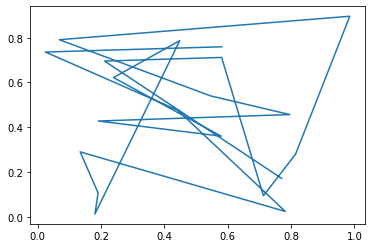

In [22]:
NN.load_state_dict(torch.load('2D_10points_big_6.9', map_location = "cuda"))
evaluate(1, 23, 1, 1)
import matplotlib.pyplot as plt
points = env.points.to("cpu").numpy() #[1, npoints, 2]
order = env.points_sequence.to("cpu").numpy() #[1, npoints]
plt.plot(points[0, order[0,:], 0], points[0, order[0,:], 1])

242.0 -296.7618408203125 nan -296.7618408203125 -296.7618408203125 0.0


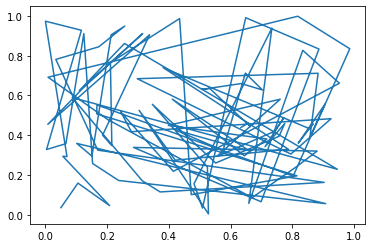

In [7]:
NN.load_state_dict(torch.load('2D_100points_250', map_location = "cuda"))
evaluate(1, 103, 1, 1)
import matplotlib.pyplot as plt
points = env.points.to("cpu").numpy() #[1, npoints, 2]
order = env.points_sequence.to("cpu").numpy() #[1, npoints]
plt.plot(points[0, order[0,:], 0], points[0, order[0,:], 1])

In [24]:
evaluate(1, 23, 1000, 1)

23.71200180053711 -5.153502941131592 nan -5.833985328674316 -5.193703651428223 0.0
